In [1]:
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister
import qiskit as qk
from qiskit import QuantumCircuit, Aer, IBMQ, execute
from qiskit import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import plot_histogram
from math import pi
import scipy
from scipy import fftpack

In [2]:
def qft_rotations(circuit, n, start_index=0):
    if n == 0: # Exit function if circuit is empty
        return circuit
    n -= 1         # Indexes start from 0
    circuit.h(start_index+n)   # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), start_index+qubit, start_index+n)
        circuit.barrier()
    qft_rotations(circuit, n, start_index)
        
def swap_registers(circuit, n, start_index=0):
    for qubit in range(n//2):
        circuit.swap(start_index+qubit, start_index+n-qubit-1)
    return circuit

import math
pi = np.pi
shots = 4096 * 40
def qft2(image, nqbits=10, shots=shots):
    # нормируем коэффициенты
    row = image.flatten()
    row = row  / sum(np.absolute(row) ** 2) ** .5
    row = row.astype('complex_')
    row_num_qub = int(math.log(image.shape[0],2))
    col_num_qub = int(math.log(image.shape[1],2))
    num_rows = QuantumRegister(row_num_qub, 'num_rows')
    num_cols = QuantumRegister(col_num_qub,'num_cols')
    cr = ClassicalRegister(row_num_qub+col_num_qub, 'cr')
    qc = QuantumCircuit(num_rows, num_cols, cr)
    qc.initialize(row, qc.qubits)
    
    qft_rotations(qc, row_num_qub)
    swap_registers(qc, row_num_qub)
    qc.barrier()
    qft_rotations(qc, col_num_qub, row_num_qub)
    swap_registers(qc, col_num_qub, row_num_qub)
    qc.barrier()
    
    qc.measure_all()
    return qc

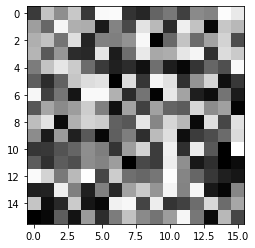

In [3]:
import numpy as np
image = np.random.randint(256, size=(16, 16))
# image[::,::4] = 255
# image[::,1::4] = 128
# image[::,3::4] = 128
# image[:,::4] = 128

plt.imshow(image, cmap = 'gray')
plt.show()
circ = qft2(image)
# circ.draw()

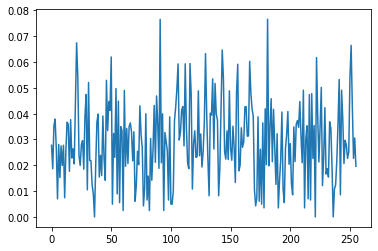

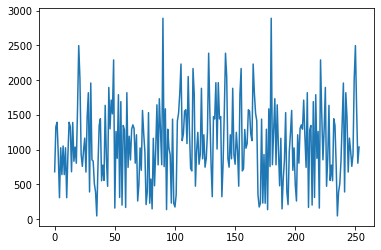

In [4]:
job = execute(circ,Aer.get_backend('qasm_simulator'), shots=shots)
counts = job.result().get_counts(circ)
data = np.zeros(image.shape[0]*image.shape[1])
for key in counts:
    for kkey in key.split():
        data[int(kkey, 2)] = (counts[key] / shots) ** .5

plt.plot(data)
plt.show()

plt.plot(abs((fftpack.fft2(image)).flatten())[1:-1])
plt.show()
